In [1]:
"""train deeplabv3."""
import os
import sys
sys.path.insert(0,'./deeplabv3/deeplabv3_2/')     # your code path
import argparse
from easydict import EasyDict as edict
import shutil

import moxing as mox

from mindspore import context
from mindspore.train.model import ParallelMode, Model
import mindspore.nn as nn
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.communication.management import init, get_rank, get_group_size
from mindspore.train.callback import LossMonitor, TimeMonitor
from mindspore.train.loss_scale_manager import FixedLossScaleManager
from mindspore.common import set_seed
from src import dataset as data_generator
from src import loss
from src import deeplab_v3
from src import learning_rates

set_seed(1)
context.set_context(mode=context.GRAPH_MODE, enable_auto_mixed_precision=True, save_graphs=False,
                    device_target="Ascend", device_id=int(os.getenv('DEVICE_ID')))


class BuildTrainNetwork(nn.Cell):
    def __init__(self, network, criterion):
        super(BuildTrainNetwork, self).__init__()
        self.network = network
        self.criterion = criterion

    def construct(self, input_data, label):
        output = self.network(input_data)
        net_loss = self.criterion(output, label)
        return net_loss

def train(args):
    # init multicards training
    if args.is_distributed:
        init()
        args.rank = get_rank()
        args.group_size = get_group_size()

        parallel_mode = ParallelMode.DATA_PARALLEL
        context.set_auto_parallel_context(parallel_mode=parallel_mode, gradients_mean=True, device_num=args.group_size)
    
    
    # dataset
    dataset = data_generator.SegDataset(image_mean=args.image_mean,
                                        image_std=args.image_std,
                                        data_file=args.data_file,
                                        batch_size=args.batch_size,
                                        crop_size=args.crop_size,
                                        max_scale=args.max_scale,
                                        min_scale=args.min_scale,
                                        ignore_label=args.ignore_label,
                                        num_classes=args.num_classes,
                                        num_readers=2,
                                        num_parallel_calls=4,
                                        shard_id=args.rank,
                                        shard_num=args.group_size)
    dataset.get_gray_dataset()
    dataset.get_mindrecord_dataset(is_training=True)
    dataset = dataset.get_dataset(repeat=1)
    

    # network
    if args.model == 'deeplab_v3_s16':
        network = deeplab_v3.DeepLabV3('train', args.num_classes, 16, args.freeze_bn)
    elif args.model == 'deeplab_v3_s8':
        network = deeplab_v3.DeepLabV3('train', args.num_classes, 8, args.freeze_bn)
    else:
        raise NotImplementedError('model [{:s}] not recognized'.format(args.model))

    # loss
    loss_ = loss.SoftmaxCrossEntropyLoss(args.num_classes, args.ignore_label)
    loss_.add_flags_recursive(fp32=True)
    train_net = BuildTrainNetwork(network, loss_)

    # load pretrained model
    param_dict = load_checkpoint(args.ckpt_file)
    load_param_into_net(train_net, param_dict)

    # optimizer
    iters_per_epoch = dataset.get_dataset_size()
    total_train_steps = iters_per_epoch * args.train_epochs
    if args.lr_type == 'cos':
        lr_iter = learning_rates.cosine_lr(args.base_lr, total_train_steps, total_train_steps)
    elif args.lr_type == 'poly':
        lr_iter = learning_rates.poly_lr(args.base_lr, total_train_steps, total_train_steps, end_lr=0.0, power=0.9)
    elif args.lr_type == 'exp':
        lr_iter = learning_rates.exponential_lr(args.base_lr, args.lr_decay_step, args.lr_decay_rate,
                                                total_train_steps, staircase=True)
    else:
        raise ValueError('unknown learning rate type')
    opt = nn.Momentum(params=train_net.trainable_params(), learning_rate=lr_iter, momentum=0.9, weight_decay=0.0001,
                      loss_scale=args.loss_scale)

    # loss scale
    manager_loss_scale = FixedLossScaleManager(args.loss_scale, drop_overflow_update=False)
    model = Model(train_net, optimizer=opt, amp_level="O3", loss_scale_manager=manager_loss_scale)

    # callback for saving ckpts
    time_cb = TimeMonitor(data_size=iters_per_epoch)
    loss_cb = LossMonitor()
    cbs = [time_cb, loss_cb]

    if args.rank == 0:
        config_ck = CheckpointConfig(save_checkpoint_steps=iters_per_epoch,
                                     keep_checkpoint_max=args.keep_checkpoint_max)
        ckpoint_cb = ModelCheckpoint(prefix=args.model, directory=args.train_dir, config=config_ck)
        cbs.append(ckpoint_cb)

    model.train(args.train_epochs, dataset, callbacks=cbs,dataset_sink_mode=True)


INFO:root:Using MoXing-v1.17.3-43fbf97f
INFO:root:Using OBS-Python-SDK-3.20.7


In [10]:
cfg = edict({
    "batch_size": 16,
    "crop_size": 513,
    "image_mean": [103.53, 116.28, 123.675],
    "image_std": [57.375, 57.120, 58.395],
    "min_scale": 0.5,
    "max_scale": 2.0,
    "ignore_label": 255,
    "num_classes": 21,
    "train_epochs" : 3,

    "lr_type": 'cos',
    "base_lr": 0.0,

    "lr_decay_step": 3*91,
    "lr_decay_rate" :0.1,

    "loss_scale": 2048,      

    "model": 'deeplab_v3_s8',
    'rank': 0,
    'group_size':1,
    'keep_checkpoint_max':1,
    'train_dir': 'model',

    'is_distributed':False,
    'freeze_bn':True
})

if os.path.exists(cfg.train_dir):
    shutil.rmtree(cfg.train_dir)
    
data_path = './VOC2012'
if not os.path.exists(data_path):
    mox.file.copy_parallel(src_url="s3://share-course/dataset/voc2012_raw/", dst_url=data_path)
cfg.data_file = data_path

ckpt_path = 'deeplab_s8.ckpt'
if not os.path.exists(ckpt_path):
    mox.file.copy_parallel(src_url="s3://share-course/checkpoint/deeplabv3/deeplab_v3_s8-800_82.ckpt", dst_url=ckpt_path)
cfg.ckpt_file = ckpt_path

train(cfg)
# if the model is needed in next time, you can save the mode file to yours obs.
mox.file.copy_parallel(src_url=cfg.train_dir, dst_url=os.path.join("s3://yyq-2/DATA/code/deeplabv3/",cfg.train_dir)) 

the gray file is already exists！
mindrecord file is already exists！
epoch: 1 step: 91, loss is 0.0060049887
Epoch time: 113901.852, per step time: 1251.669
epoch: 2 step: 91, loss is 0.005827518
Epoch time: 47794.906, per step time: 525.219
epoch: 3 step: 91, loss is 0.006527958
Epoch time: 47767.277, per step time: 524.915


In [6]:
"""eval deeplabv3."""
import os
import sys
sys.path.insert(0,'./deeplabv3/deeplabv3_2/')     # your code path
import argparse
from easydict import EasyDict as edict
from PIL import Image
import PIL

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import numpy as np
import cv2
import moxing as mox

from mindspore import Tensor
import mindspore.common.dtype as mstype
import mindspore.nn as nn
from mindspore import context
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from src import deeplab_v3
from src import dataset as data_generator

context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", save_graphs=False,
                    device_id=int(os.getenv('DEVICE_ID')))


def cal_hist(a, b, n):
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(np.int32) + b[k], minlength=n ** 2).reshape(n, n)


def resize_long(img, long_size=513):
    h, w, _ = img.shape
    if h > w:
        new_h = long_size
        new_w = int(1.0 * long_size * w / h)
    else:
        new_w = long_size
        new_h = int(1.0 * long_size * h / w)
    imo = cv2.resize(img, (new_w, new_h))
    return imo


class BuildEvalNetwork(nn.Cell):
    def __init__(self, network):
        super(BuildEvalNetwork, self).__init__()
        self.network = network
        self.softmax = nn.Softmax(axis=1)

    def construct(self, input_data):
        output = self.network(input_data)
        output = self.softmax(output)
        return output


def pre_process(args, img_, crop_size=513):
    # resize
    img_ = resize_long(img_, crop_size)
    resize_h, resize_w, _ = img_.shape

    # mean, std
    image_mean = np.array(args.image_mean)
    image_std = np.array(args.image_std)
    img_ = (img_ - image_mean) / image_std

    # pad to crop_size
    pad_h = crop_size - img_.shape[0]
    pad_w = crop_size - img_.shape[1]
    if pad_h > 0 or pad_w > 0:
        img_ = cv2.copyMakeBorder(img_, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)

    # hwc to chw
    img_ = img_.transpose((2, 0, 1))
    return img_, resize_h, resize_w


def eval_batch(args, eval_net, img_lst, crop_size=513, flip=True):
    result_lst = []
    batch_size = len(img_lst)
    batch_img = np.zeros((args.batch_size, 3, crop_size, crop_size), dtype=np.float32)
    resize_hw = []
    for l in range(batch_size):
        img_ = img_lst[l]
        img_, resize_h, resize_w = pre_process(args, img_, crop_size)
        batch_img[l] = img_
        resize_hw.append([resize_h, resize_w])

    batch_img = np.ascontiguousarray(batch_img)
    net_out = eval_net(Tensor(batch_img, mstype.float32))
    net_out = net_out.asnumpy()

    if flip:
        batch_img = batch_img[:, :, :, ::-1]
        net_out_flip = eval_net(Tensor(batch_img, mstype.float32))
        net_out += net_out_flip.asnumpy()[:, :, :, ::-1]

    for bs in range(batch_size):
        probs_ = net_out[bs][:, :resize_hw[bs][0], :resize_hw[bs][1]].transpose((1, 2, 0))
        ori_h, ori_w = img_lst[bs].shape[0], img_lst[bs].shape[1]
        probs_ = cv2.resize(probs_, (ori_w, ori_h))
        result_lst.append(probs_)

    return result_lst


def eval_batch_scales(args, eval_net, img_lst, scales,
                      base_crop_size=513, flip=True):
    sizes_ = [int((base_crop_size - 1) * sc) + 1 for sc in scales]
    probs_lst = eval_batch(args, eval_net, img_lst, crop_size=sizes_[0], flip=flip)
    #print(sizes_)
    for crop_size_ in sizes_[1:]:
        probs_lst_tmp = eval_batch(args, eval_net, img_lst, crop_size=crop_size_, flip=flip)
        for pl, _ in enumerate(probs_lst):
            probs_lst[pl] += probs_lst_tmp[pl]

    result_msk = []
    for i in probs_lst:
        result_msk.append(i.argmax(axis=2))
    return result_msk

# The color source: print(list(colors.cnames.keys()))
#print(list(colors.cnames.keys()))
num_class = {0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat',
             9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant',
             17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor', 21: 'edge'}

num_color = {0:'aliceblue', 1:'grey', 2:'red', 3:'green', 4:'darkorange', 5:'lime', 6:'bisque',
     7:'black', 8:'blanchedalmond', 9:'blue', 10:'blueviolet', 11:'brown', 12:'burlywood', 13:'cadetblue', 
     14:'darkorange', 15:'tan', 16:'darkviolet', 17:'cornflowerblue', 18:'yellow', 19:'crimson', 20:'darkcyan'}

color_dic = [num_color[k] for k in sorted(num_color.keys())]
bounds = list(range(21))
cmap = mpl.colors.ListedColormap(color_dic)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

def num_to_ClassAndColor(num_list):
    color_ = []
    class_ = []
    for num in num_list:
        color_.append(num_class[num])
        class_.append(num_color[num])
    return color_,class_


def net_eval(args):
    # network
    if args.model == 'deeplab_v3_s16':
        network = deeplab_v3.DeepLabV3('eval', args.num_classes, 16, args.freeze_bn)
    elif args.model == 'deeplab_v3_s8':
        network = deeplab_v3.DeepLabV3('eval', args.num_classes, 8, args.freeze_bn)
    else:
        raise NotImplementedError('model [{:s}] not recognized'.format(args.model))

    eval_net = BuildEvalNetwork(network)

    # load model
    param_dict = load_checkpoint(args.ckpt_file)
    load_param_into_net(eval_net, param_dict)
    eval_net.set_train(False)
    
    # data list
    with open(args.data_lst) as f:
        img_lst = f.readlines()
        
    # evaluate
    hist = np.zeros((args.num_classes, args.num_classes))
    batch_img_lst = []
    batch_msk_lst = []
    bi = 0
    image_num = 0
    for i, line in enumerate(img_lst):
        id_ = line.strip()
        img_path = os.path.join(cfg.voc_img_dir, id_ + '.jpg')
        msk_path = os.path.join(cfg.voc_anno_gray_dir, id_ + '.png')
            
        img_ = cv2.imread(img_path)
        msk_ = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
        batch_img_lst.append(img_)
        batch_msk_lst.append(msk_)
        if args.if_png:
            batch_res = eval_batch_scales(args, eval_net, batch_img_lst, scales=args.scales,
                                          base_crop_size=args.crop_size, flip=args.flip)
            
            height ,weight = batch_res[0].shape
            batch_msk_lst[0][batch_msk_lst[0]==args.ignore_label] = 0
            
            plt.figure(figsize=(3 * weight/1024*10, 2 * height/1024*10))
            plt.subplot(1,3,1)
            image = Image.open(img_path)
            plt.imshow(image)
            
            plt.subplot(1,3,2)
            plt.imshow(image)
            plt.imshow(batch_res[0],alpha=0.8,interpolation='none', cmap=cmap, norm=norm)
            
            
            plt.subplot(1,3,3)
            plt.imshow(image)
            plt.imshow(batch_msk_lst[0],alpha=0.8,interpolation='none', cmap=cmap, norm=norm)
            plt.show()
            
            prediction_num = np.unique(batch_res[0])
            real_num = np.unique(batch_msk_lst[0])
            
            prediction_color,prediction_class = num_to_ClassAndColor(prediction_num)
            print('prediction num:',prediction_num)
            print('prediction color:',prediction_color)
            print('prediction class:',prediction_class)
            real_color,real_class = num_to_ClassAndColor(real_num)
            print('groundtruth num:',real_num)
            print('groundtruth color:',real_color)
            print('groundtruth class:',real_class)
            batch_img_lst = []
            batch_msk_lst = []
            if i < args.num_png-1:
                continue
            else:
                return
            
        bi += 1
        if bi == args.batch_size:
            batch_res = eval_batch_scales(args, eval_net, batch_img_lst, scales=args.scales,
                                          base_crop_size=args.crop_size, flip=args.flip)
            for mi in range(args.batch_size):
                hist += cal_hist(batch_msk_lst[mi].flatten(), batch_res[mi].flatten(), args.num_classes)

            bi = 0
            batch_img_lst = []
            batch_msk_lst = []
            if (i+1)%100 == 0:
                print('processed {} images'.format(i+1))
        image_num = i

    if bi > 0:
        batch_res = eval_batch_scales(args, eval_net, batch_img_lst, scales=args.scales,
                                      base_crop_size=args.crop_size, flip=args.flip)
        for mi in range(bi):
            hist += cal_hist(batch_msk_lst[mi].flatten(), batch_res[mi].flatten(), args.num_classes)
        if (i+1) % 100 == 0:
            print('processed {} images'.format(image_num + 1))

    iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
    print('mean IoU', np.nanmean(iu))

In [4]:
# test  1
cfg = edict({
    "batch_size": 1,
    "crop_size": 513,
    "image_mean": [103.53, 116.28, 123.675],
    "image_std": [57.375, 57.120, 58.395],
    "scales": [1.0],           # [0.5,0.75,1.0,1.25,1.75]
    'flip': True,

    'ignore_label': 255,
    'num_classes':21,

    'model': 'deeplab_v3_s8',
    'freeze_bn': True,
    
    'if_png':False,
    'num_png':10
})


data_path = './VOC2012'
if not os.path.exists(data_path):
    mox.file.copy_parallel(src_url="s3://share-course/dataset/voc2012_raw/", dst_url=data_path)
cfg.data_file = data_path

# dataset
dataset = data_generator.SegDataset(image_mean=cfg.image_mean,
                                    image_std=cfg.image_std,
                                    data_file=cfg.data_file)
dataset.get_gray_dataset()
cfg.data_lst = os.path.join(cfg.data_file,'ImageSets/Segmentation/val.txt')
cfg.voc_img_dir = os.path.join(cfg.data_file,'JPEGImages')
cfg.voc_anno_gray_dir = os.path.join(cfg.data_file,'SegmentationClassGray')

ckpt_path = './model'
if not os.path.exists(ckpt_path):
    mox.file.copy_parallel(src_url="s3://yyq-3/DATA/code/deeplabv3/model", dst_url=ckpt_path)   #if yours model had saved
cfg.ckpt_file = os.path.join(ckpt_path,'deeplab_v3_s8-3_91.ckpt')  
print('loading checkpoing:',cfg.ckpt_file)

net_eval(cfg)

the gray file is already exists！
loading checkpoing: ./model/deeplab_v3_s8-3_91.ckpt
processed 100 images
processed 200 images
processed 300 images
processed 400 images
processed 500 images
processed 600 images
processed 700 images
processed 800 images
processed 900 images
processed 1000 images
processed 1100 images
processed 1200 images
processed 1300 images
processed 1400 images
mean IoU 0.7709573541968988


the gray file is already exists！
loading checkpoing: ./model/deeplab_v3_s8-3_91.ckpt


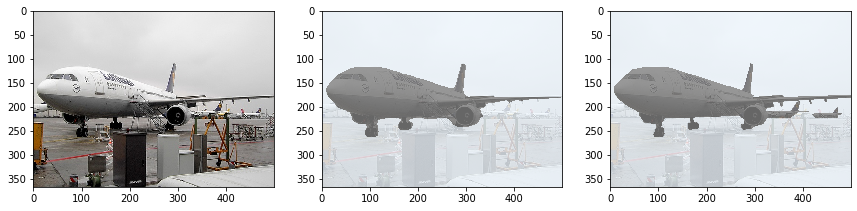

prediction num: [ 0  1 15]
prediction color: ['background', 'aeroplane', 'person']
prediction class: ['aliceblue', 'grey', 'tan']
groundtruth num: [0 1]
groundtruth color: ['background', 'aeroplane']
groundtruth class: ['aliceblue', 'grey']


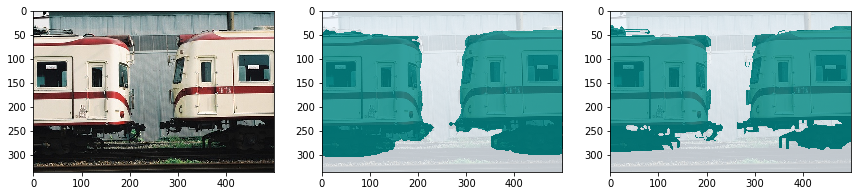

prediction num: [ 0 19]
prediction color: ['background', 'train']
prediction class: ['aliceblue', 'crimson']
groundtruth num: [ 0 19]
groundtruth color: ['background', 'train']
groundtruth class: ['aliceblue', 'crimson']


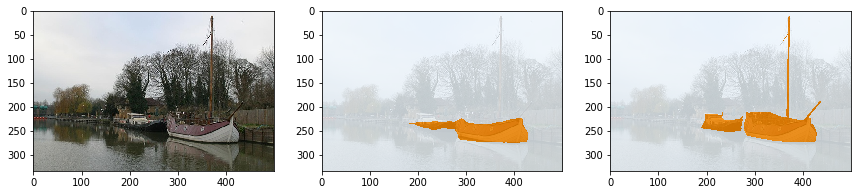

prediction num: [0 4]
prediction color: ['background', 'boat']
prediction class: ['aliceblue', 'darkorange']
groundtruth num: [0 4]
groundtruth color: ['background', 'boat']
groundtruth class: ['aliceblue', 'darkorange']


In [9]:
# test 2
cfg = edict({
    "batch_size": 1,
    "crop_size": 513,
    "image_mean": [103.53, 116.28, 123.675],
    "image_std": [57.375, 57.120, 58.395],
    "scales": [1.0],           # [0.5,0.75,1.0,1.25,1.75]
    'flip': True,

    'ignore_label': 255,
    'num_classes':21,

    'model': 'deeplab_v3_s8',
    'freeze_bn': True,
    
    'if_png':True,
    'num_png':3

})

import moxing as mox
data_path = './VOC2012'
if not os.path.exists(data_path):
    mox.file.copy_parallel(src_url="s3://share-course/dataset/voc2012_raw/", dst_url=data_path)
cfg.data_file = data_path

# dataset
dataset = data_generator.SegDataset(image_mean=cfg.image_mean,
                                    image_std=cfg.image_std,
                                    data_file=cfg.data_file)
dataset.get_gray_dataset()
cfg.data_lst = os.path.join(cfg.data_file,'ImageSets/Segmentation/val.txt')
cfg.voc_img_dir = os.path.join(cfg.data_file,'JPEGImages')
cfg.voc_anno_gray_dir = os.path.join(cfg.data_file,'SegmentationClassGray')

ckpt_path = './model'
if not os.path.exists(ckpt_path):
    mox.file.copy_parallel(src_url="s3://yyq-3/DATA/code/deeplabv3/model", dst_url=ckpt_path)     #if yours model had saved
cfg.ckpt_file = os.path.join(ckpt_path,'deeplab_v3_s8-3_91.ckpt')  
print('loading checkpoing:',cfg.ckpt_file)

net_eval(cfg)